<a href="https://colab.research.google.com/github/guilherminog/tcc_timeseries/blob/main/ajuste_sariamax_por_loja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ignorar avisos
import warnings
warnings.filterwarnings("ignore")


In [39]:
# Carregar o dataset a partir do URL
url = 'https://raw.githubusercontent.com/guilherminog/tcc_timeseries/main/dataset/Walmart.csv'
df = pd.read_csv(url)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [41]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [42]:
df_store = df[df['Store'] == 1]

In [43]:
df_store = df_store.sort_values('Date')


In [45]:
endog = df_store['Weekly_Sales']
exog = df_store[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

In [46]:
# Verificar se há valores nulos
print(df_store.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [47]:
# Verificar se há valores nulos
print(df_store.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [48]:
# Definir a proporção de treino
train_size = int(len(endog) * 0.8)

# Dividir os dados
endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [49]:
# Definir os parâmetros do modelo
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 52)  # Sazonalidade semanal ao longo de um ano

In [50]:
# Ajustar o modelo
model = sm.tsa.SARIMAX(endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Exibir um resumo do modelo
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -772.134
Date:                            Wed, 13 Nov 2024   AIC                           1564.268
Time:                                    00:13:29   BIC                           1585.377
Sample:                                         0   HQIC                          1572.541
                                            - 114                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Holiday_Flag     0.0118   2919.985   4.04e-06      1.000   -5723.053    5723.077
Temperature   1521.6066   122

In [12]:
# Fazer previsões
predictions = model_fit.predict(start=endog_test.index[0], end=endog_test.index[-1], exog=exog_test)


In [13]:
# Valores reais
actual = endog_test

# Calcular MSE
mse = np.mean((predictions - actual) ** 2)

# Calcular RMSE
rmse = np.sqrt(mse)

# Calcular MAE
mae = np.mean(np.abs(predictions - actual))

# Calcular MAPE
mape = np.mean(np.abs((actual - predictions) / actual)) * 100

# Exibir as métricas
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 81443773049.29
RMSE: 285383.55
MAE: 274722.83
MAPE: 17.64%


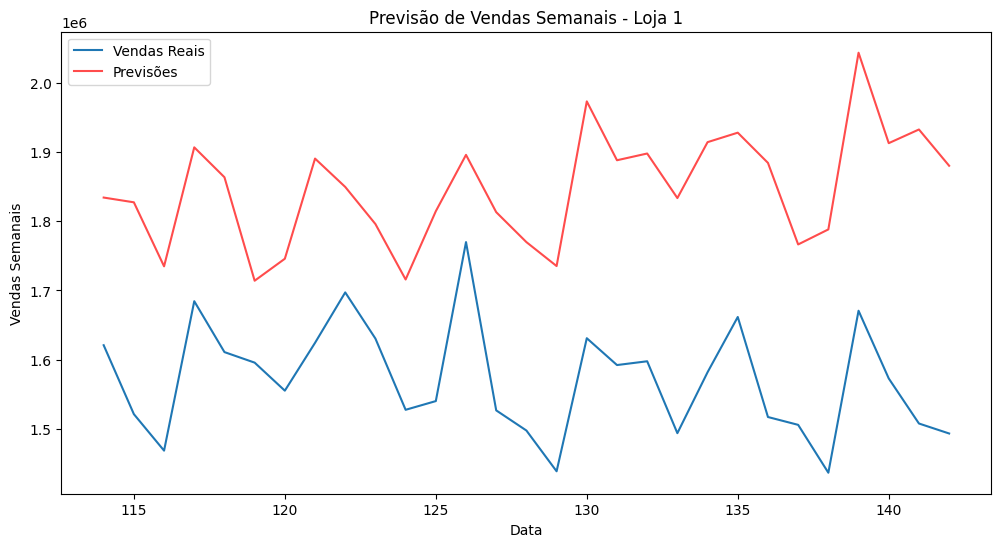

In [14]:
# Plotar os valores reais vs previsões
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual, label='Vendas Reais')
plt.plot(predictions.index, predictions, label='Previsões', color='red', alpha=0.7)
plt.title('Previsão de Vendas Semanais - Loja 1')
plt.xlabel('Data')
plt.ylabel('Vendas Semanais')
plt.legend()
plt.show()


---

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Adicionar constante para o cálculo do VIF
exog_with_const = sm.add_constant(exog)
vif_data = pd.DataFrame()
vif_data["Variável"] = exog.columns
vif_data["VIF"] = [variance_inflation_factor(exog_with_const.values, i+1) for i in range(len(exog.columns))]
print(vif_data)


       Variável       VIF
0  Holiday_Flag  1.055560
1   Temperature  1.143015
2    Fuel_Price  2.708650
3           CPI  5.771458
4  Unemployment  3.362415


In [16]:
# Atualizar as variáveis exógenas
exog_reduced = exog[['Unemployment']]

# Dividir novamente em treino e teste
exog_train_reduced = exog_reduced.iloc[:train_size]
exog_test_reduced = exog_reduced.iloc[train_size:]

# Reajustar o modelo
model_reduced = sm.tsa.SARIMAX(endog_train, exog=exog_train_reduced, order=order, seasonal_order=seasonal_order)
model_fit_reduced = model_reduced.fit(disp=False)

# Fazer previsões
predictions_reduced = model_fit_reduced.predict(start=endog_test.index[0], end=endog_test.index[-1], exog=exog_test_reduced)

# Calcular as métricas de erro
mse_reduced = np.mean((predictions_reduced - actual) ** 2)
rmse_reduced = np.sqrt(mse_reduced)
mae_reduced = np.mean(np.abs(predictions_reduced - actual))
mape_reduced = np.mean(np.abs((actual - predictions_reduced) / actual)) * 100

# Exibir as métricas
print(f"MSE: {mse_reduced:.2f}")
print(f"RMSE: {rmse_reduced:.2f}")
print(f"MAE: {mae_reduced:.2f}")
print(f"MAPE: {mape_reduced:.2f}%")


MSE: 93035484270.51
RMSE: 305017.19
MAE: 294918.74
MAPE: 18.94%


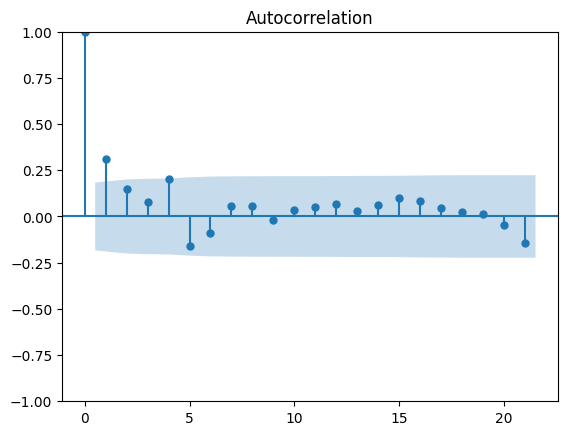

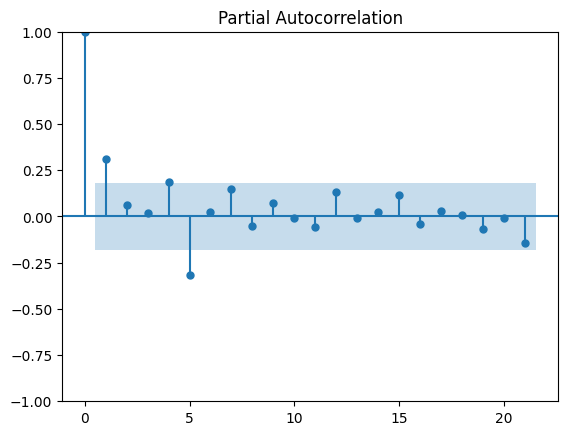

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar ACF e PACF
plot_acf(endog_train)
plt.show()

plot_pacf(endog_train)
plt.show()


In [18]:
# Aplicar transformação logarítmica
endog_log = np.log(endog)

# Dividir os dados transformados
endog_log_train = endog_log.iloc[:train_size]
endog_log_test = endog_log.iloc[train_size:]

# Reajustar o modelo com dados transformados
model_log = sm.tsa.SARIMAX(endog_log_train, exog=exog_train_reduced, order=order, seasonal_order=seasonal_order)
model_fit_log = model_log.fit(disp=False)

# Fazer previsões
predictions_log = model_fit_log.predict(start=endog_log_test.index[0], end=endog_log_test.index[-1], exog=exog_test_reduced)

# Reverter a transformação
predictions_log_exp = np.exp(predictions_log)

# Calcular as métricas de erro
mse_log = np.mean((predictions_log_exp - actual) ** 2)
rmse_log = np.sqrt(mse_log)
mae_log = np.mean(np.abs(predictions_log_exp - actual))
mape_log = np.mean(np.abs((actual - predictions_log_exp) / actual)) * 100

# Exibir as métricas
print(f"MSE: {mse_log:.2f}")
print(f"RMSE: {rmse_log:.2f}")
print(f"MAE: {mae_log:.2f}")
print(f"MAPE: {mape_log:.2f}%")

MSE: 10594125144.95
RMSE: 102927.77
MAE: 91210.81
MAPE: 5.85%


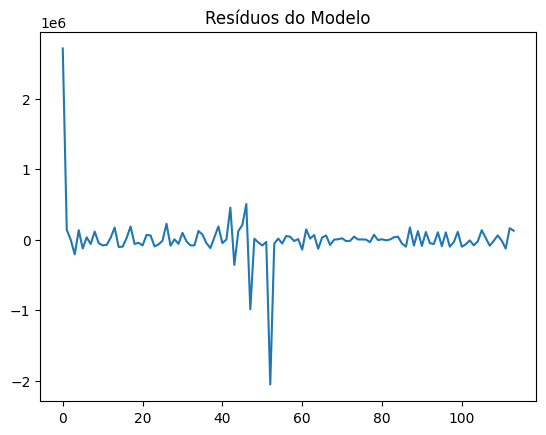

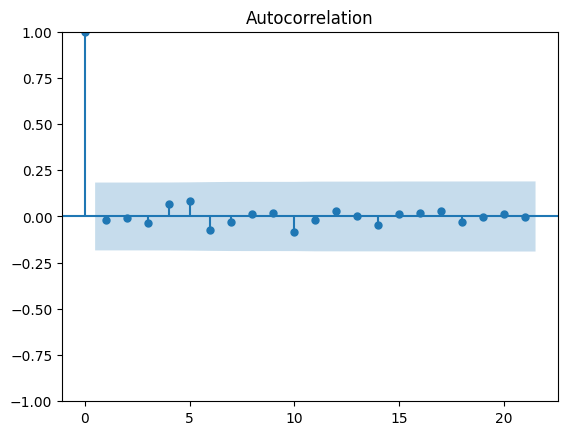

In [19]:
# Plotar resíduos
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Resíduos do Modelo')
plt.show()

# Plotar ACF dos resíduos
plot_acf(residuals)
plt.show()